<a href="https://colab.research.google.com/github/freethechicken/pbh_simulations/blob/main/LRZ_multiprocessing_simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# @title Import packages

import multiprocessing
import cupy as cp
import numpy as np
from cupyx.scipy.special import erf
import matplotlib.pyplot as plt

import gc
import os

#from scipy.special import erf
from sklearn.cluster import DBSCAN
from sklearn.metrics.pairwise import euclidean_distances
from tqdm import tqdm


In [ ]:
# @title 1.11 GPU Random field simulations

class GPU_RFSIM:

    def __init__(self, mean, std_dev, pixel, z_pixel, amplitude, k_power, lamb, n_sigma):
        self.mean = mean
        self.std_dev = std_dev
        self.pixel = pixel
        self.z_pixel = z_pixel
        self.amplitude = amplitude
        self.k_power = k_power
        self.lamb = lamb
        self.n_sigma = n_sigma

    def grf_64f(self):
        # 3D Fast Fourier transform of the white noise
        white_noise = cp.random.normal(self.mean, self.std_dev, (self.pixel, self.pixel, self.z_pixel))

        fft_white_noise = cp.fft.fftn(white_noise)
        del white_noise

        # Generating FFT momentum
        kx = cp.fft.fftfreq(self.pixel)*self.pixel
        ky = cp.fft.fftfreq(self.pixel)*self.pixel
        kz = cp.fft.fftfreq(self.z_pixel)*self.z_pixel

        kx_grid, ky_grid, kz_grid = cp.meshgrid(kx, ky, kz, sparse = True)
        del kx, ky, kz
        # Genearting FFT momentum 3D array
        # Norm of k

        k_norm = cp.sqrt(kx_grid**2 + ky_grid**2  + kz_grid**2)
        k_norm[0][0][0] = cp.inf  # Regularize divergence at k=0
        del kx_grid, ky_grid, kz_grid

        # Power Spectrum P_k
        power_spectrum = (self.amplitude*(((2*cp.pi/self.pixel)*k_norm)**(-1*self.k_power)))  # P(k)=amplitude/k^{power},
        del k_norm

        # Multiply the power spectrum with the transformed white noise to get the realization of the spectrum
        fourier_amplitudes_sqrt =  cp.sqrt(power_spectrum, out=power_spectrum)*fft_white_noise
        del power_spectrum, fft_white_noise

        # Perform inverse Fourier transform to obtain the Gaussian random field in the spatial domain
        gaussian_random_field = cp.fft.ifftn(fourier_amplitudes_sqrt).real
        del fourier_amplitudes_sqrt
        gc.collect()

        return gaussian_random_field


    def gaussian_to_exp(self, grf):
        grf_mean = cp.mean(grf)
        grf_std_dev = cp.std(grf)
        xu = 0.5 * (1 + erf((grf - grf_mean) / (cp.sqrt(2) * grf_std_dev)))

        gc.collect()

        exprf = -1/self.lamb  * cp.log(1 - xu)

        return exprf
#        return gaussian_random_field

    def statistic_overview(self, exprf):

        all_points = cp.asnumpy(exprf.flatten())
        exprf_std = np.std(all_points)
        exprf_mean = np.mean(all_points)
        cutoff = exprf_mean + self.n_sigma*exprf_std

        plt.style.use('seaborn-darkgrid')

        # Create a figure object
        fig, ax = plt.subplots()

        ax.hist(all_points, bins=100)
        ax.set_yscale('log')
        ax.set_xlabel('Field amplitude', fontsize=12)
        ax.set_ylabel('Number of data points (Log)', fontsize=12)
        ax.axvline(x=cutoff, color='r', linestyle='-', label='Cutoff amplitude')

        # Add text to the plot
        textstr = f'Std. Dev. = {exprf_std:.2f}\nMean = {exprf_mean:.2f}\nCutoff = {cutoff:.2f} ({n_sigma} Std. Dev. from mean)'
        ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=10,
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

        ax.set_title('Random Field Statistics', fontsize=14)
        ax.legend(loc='upper right')
        ax.grid(True, which='both', linestyle='--', linewidth=0.5)

        # Save the plot with text
        plt.show()

        return fig, cutoff, exprf_std, exprf_mean

In [ ]:
# @title 1.12 GPU Cluster analysis

class GPU_CLUST_ANALY:

    def __init__(self, exprf, pixel, z_pixel):
        self.pixel = pixel
        self.z_pixel = z_pixel
        self.exprf = exprf

    def masking(self, cutoff):
        # 5. Save mask and positions where amplitude exceed threshold
        mask = cp.abs(self.exprf) > cutoff
        masked_positions = cp.argwhere(mask)
        # cp.save(f'mask_at_{cutoff:.1f}.npy', mask)
        # cp.save(f'mask_positions_at_{cutoff:.1f}.npy', masked_positions)

        return masked_positions

    def dbscan(self, eps, min_sam, masked_positions):
        dbscans = DBSCAN(eps=eps, min_samples=min_sam)
        cluster_labels = dbscans.fit_predict(masked_positions)

        return cluster_labels

    def submanifolds(self, masked_positions, lx, ly, lz):
        sub_manifolds_list={}
        total_mass={}

        for ii in range(masked_positions.shape[0]):
            x, y, z = masked_positions[ii]
            x_min, x_max = max(x- lx,0), min(x+ lx +1, self.pixel)
            y_min, y_max = max(y- ly,0), min(y+ ly +1, self.pixel)
            z_min, z_max = max(z- lz,0), min(z+ lz +1, self.z_pixel)

            sub_exprf = self.exprf[x_min:x_max, y_min:y_max, z_min:z_max]
            sub_manifolds_list[ii] = sub_exprf
            total_mass[ii] = cp.sum(sub_exprf)

        cp.save(f'sub_manifolds_list.npy', sub_manifolds_list )
        cp.save(f'total_amplitude.npy', total_mass)

        return sub_manifolds_list, total_mass

        # @title 1.4 DBSCAN

    def cluster_distances(self, masked_positions, labels):
        cluster_centers = {}

        # Find unique cluster labels (excluding noise -1)
        unique_labels = set(labels) - {-1}

        # Calculate cluster centers
        for ii in set(unique_labels):
            cluster_indices = cp.where(labels == ii)[0]
            cluster_positions = masked_positions[cluster_indices]
            cluster_center = cp.mean(cluster_positions, axis=0)
            cluster_centers[ii] = cluster_center

        # Calculate distances between cluster centers
        distances = []
        for aa in cluster_centers:
            for bb in cluster_centers:
                if aa != bb & bb > aa:
                    distance = euclidean_distances([cluster_centers[aa]], [cluster_centers[bb]])
                    distances.append((aa,bb, distance))

        return distances


    def cluster_distribution_3d(self, positions, labels):

        all_cluster_position = {}
        cluster_field_values={}
        for ii in set(labels):
            cluster_indices = cp.where(labels == ii)[0]
            all_cluster_position[ii+1] = positions[cluster_indices]
            cluster_field_values[ii+1] = self.exprf[all_cluster_position[ii+1][:,0],
                                            all_cluster_position[ii+1][:,1],
                                            all_cluster_position[ii+1][:,2]]

        for ii in set(labels):
            plt.hist(cluster_field_values[ii+1].flatten(), bins = 100, label=f'Cluster {ii}', alpha=0.3);
            #plt.yscale('log')
            plt.xlabel('Field amplitude')
            plt.ylabel('Number of samples')
            plt.title(f'Cluster Distribution')
            plt.legend(loc='upper right', bbox_to_anchor=(1, 1))
            plt.grid(True)

        return cluster_field_values


    def cluster_plot_3D(self, positions, labels):

        fig = plt.figure(figsize=(5, 5))
        ax = fig.add_subplot(111, projection='3d')

        for ii in set(labels):
            cluster_index = cp.where(labels == ii)[0]
            cluster_positions = positions[cluster_index]

            if ii == -1:
                ax.scatter(-cluster_positions[:, 0], cluster_positions[:, 1], cluster_positions[:, 2],
                        s=3, color='black', label='Anomaly')
            else:
                ax.scatter(-cluster_positions[:, 0], cluster_positions[:, 1], cluster_positions[:, 2],
                        s=3, label=f'Cluster {ii}')

        ax.set_xlabel('X', fontsize=10)
        ax.set_ylabel('Y', fontsize=10)
        ax.set_zlabel('Z', fontsize=10)
        ax.set_title(f'Clustered 3D field config', fontsize=14)
        plt.legend()
        plt.show()

In [ ]:
# @title Paramters

num_gpu = 1 #number of GPU

pixel = 2**9
z_pixel = pixel
n_sigma = 25


eps = 25
min_sam = 5
cluster_cutoff = 13


default_l = 6 # This is the length from the center to the edge
lx = default_l
ly = default_l
lz = default_l

Nloops = 3000
update_interval = int(Nloops/10)

Current Working Directory: /content
Simulation 0/3000 in GPU 0
Found rare event at simulation 8 on GPU 0


<ipython-input-8-d9e7169424e8>:71: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


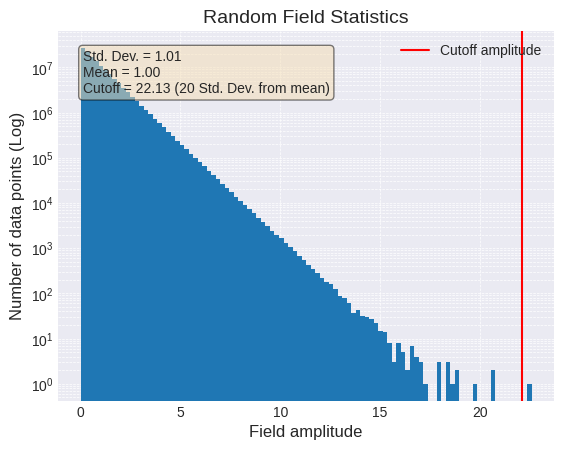

Found rare event at simulation 11 on GPU 0


<ipython-input-8-d9e7169424e8>:71: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


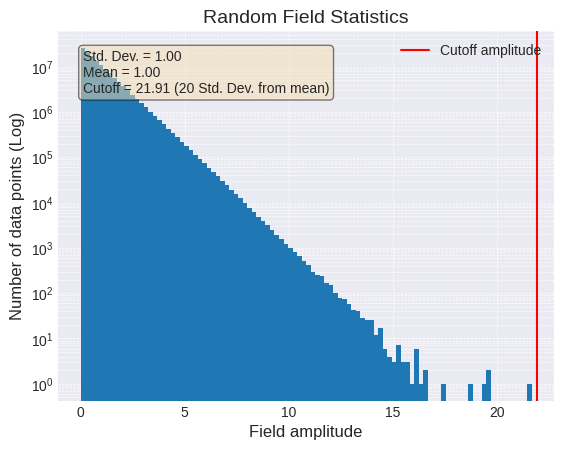

In [ ]:
# @title Run Multiprocessing Simulation

folder_path = '/content'
os.chdir(folder_path)
print("Current Working Directory:", os.getcwd())

def execute_gpu_simulation(gpu_id):

    # Set the GPU device for this process
    cp.cuda.Device(gpu_id).use()

    # Initialize an instance of RFSIM
    rfsim = GPU_RFSIM(mean=0, std_dev=1, pixel=pixel, z_pixel=z_pixel, amplitude=1.0, k_power=3, lamb=1.0, n_sigma=n_sigma+1)

    for ii in range(Nloops):

        if ii % update_interval == 0:
            print(f'Simulation {ii}/{Nloops} in GPU {gpu_id}')
        #for ii in tqdm(range(Nloops), desc="Processing", miniters=update_interval):
        # Generate a Gaussian random field
        grf = rfsim.grf_64f()  # grf can be _32f or _64f
        # Apply Gaussian to Exp. transformation
        exprf = rfsim.gaussian_to_exp(grf)
        del grf
        #gc.collect()

        # Initialize GPU cluster analysis
        clust_analy = GPU_CLUST_ANALY(exprf=exprf,  pixel=pixel, z_pixel=z_pixel)
        # Check if masked_positions is empty
        masked_positions = clust_analy.masking(cutoff = n_sigma+1)

        if len(masked_positions) > 0:
            print(f'Found rare event at simulation {ii} on GPU {gpu_id}')
            #new_folder = f"simulated_field_{ii}_gpu{gpu_id}"
            #new_path = f"simulated_field_{ii}/"
            #os.makedirs(new_folder, exist_ok=True)
            stat_fig, cutoff, exprf_std, exprf_mean = rfsim.statistic_overview(exprf)
            stat_fig.savefig(  f'Statistic_{ii}_Threshold_at_{cutoff:.1f}_gpu{gpu_id}.pdf')
            cp.save(  f'exprf_{ii}_gpu{gpu_id}.npy',exprf)

        del exprf

if __name__ == '__main__':

    # Create a multiprocessing pool for GPU
    pool = multiprocessing.Pool(processes=num_gpu)

    # Define GPU ID
    gpu_ids = range(num_gpu)
    #progress_bar = tqdm(total=Nloops, desc="Simulations", miniters = update_interval)

    # Map the simulation to GPU
    pool.map(execute_gpu_simulation, gpu_ids)

    # Parallel simulation with updated progress bar
    #for result in pool.imap_unordered(execute_gpu_simulation, gpu_ids):
    #    # Update progress bar for each completed simulation
    #    progress_bar.update(1)

    pool.close()
    pool.join()